In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectPercentile, chi2, SelectKBest
import matplotlib.pyplot as plt

# load data

In [2]:
feature = pd.read_csv('./result/featuresV1.csv')
feature = feature[['alert_key', 'trade_amount_usd', 'amt_sum',
       'amt_std', 'd_cur_type', 'day', 'trans_no_final', 'd_cur_type_ratio',
       'sum_0', 'sum_1', 'var_0', 'var_1', 'transnation_rate',
       'total_amount_money_in', 'total_amount_money_out', 'var_money_in',
       'var_money_out', 'cross_bank_rate', 'risk_rank',
       'occupation_code', 'total_asset', 'AGE', 'lupay_max', 'lupay_std',
       'clamt_max', 'clamt_std', 'csamt_max', 'csamt_std', 'inamt_max',
       'inamt_std', 'cucsm_max', 'cucsm_std', 'cucah_max', 'cucah_std',
       'cytocam_times', 'cytocam_first', 'cytocam_last', 'cytocam_variance']]

In [3]:
target = pd.read_csv('./data/train_y_answer.csv')
feature_public = pd.DataFrame([])
for i in range(len(feature)):
    if feature['alert_key'].iloc[i] not in list(target.alert_key):
        dp_t = pd.DataFrame(np.array([np.array(feature.iloc[i])]), columns = feature.columns)
        feature_public = pd.concat([feature_public, dp_t])
alert_key_f = target.alert_key
target.set_index('alert_key', inplace = True)
feature.set_index('alert_key', inplace = True)

feature = feature.reindex(target.index)
feature = pd.concat([feature, target], axis = 1)
alert_key = feature_public.alert_key
feature_public.set_index('alert_key', inplace = True)
feature_public = feature_public.fillna(0)
feature = feature.fillna(0)

In [14]:
df = feature
df_public = feature_public

In [15]:
class DNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DNN, self).__init__()
        self.dnn = nn.Sequential(nn.Linear(input_size,256),
                                 nn.Tanh(),
                                 nn.Linear(256,128),
                                 nn.Tanh(),
                                 nn.Linear(128,32),
                                 nn.Tanh(),
                                 nn.Linear(32,num_classes))
    def forward(self, x):
        output = self.dnn(x)
        return output

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
class seqDataset(Dataset):
    def __init__(self, data):
        #print(data.shape)
        self.n_samples = data.shape[0]
        self.seq_data = torch.from_numpy(data).to(device)
    def __getitem__(self, index):
        return self.seq_data[index]
    def __len__(self):
        
        return self.n_samples

In [18]:
def score(y_true: pd.DataFrame, y_pred: pd.DataFrame):
    """ 
    y_true - pandas.DataFrame: alert_key | sar_flag
    y_pred - pandas.DataFrame: alert_key | prob  
    """
    n = len(y_true[y_true.sar_flag==1]) # Num sar
    sar = y_true[y_true.sar_flag==1].alert_key.values # sar alert keys
    y_pred.sort_values(by=['probability'], ascending=False, inplace=True)
    hit = 0
    for i, y_pred_ in enumerate(y_pred.alert_key.values):
        if y_pred_ in sar:
            hit += 1
        if hit == n-1:
            break
    return (n-1)/(i+1), n-1, i

In [19]:
answer = pd.read_csv('./data/24_ESun_public_y_answer.csv')
answer.set_index('alert_key', inplace = True)
answer.reindex(df_public.index)
df_public['sar_flag'] = answer.sar_flag

In [20]:
epoch_num =20
batch_size = 256
X_df = df.iloc[:,:-1].values.astype(np.float32)
y_df = df.iloc[:,-1].values
X_df_public = df_public.iloc[:,:-1].values.astype(np.float32)
y_df_public = df_public.iloc[:,-1].values



# training

In [21]:

train_dataset = seqDataset(np.hstack((X_df,y_df[:,np.newaxis].astype(int))))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=False)

val_dataset = seqDataset(np.hstack((X_df_public,y_df_public[:,np.newaxis].astype(int))))
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=False)   
model = DNN(37,2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6) 
loss_all = []
loss_all_val = []
score_all = []
score_all_val = []
acc_all = []
acc_all_val = []
epoch_all = []
for epoch in range(epoch_num):
    epoch_all.append(epoch)
    model.train()
    total_loss = 0
    n_sample = 0
    # test = 0
    loss_t = 0
    loss_t_val = 0
    y_pred_ = []
    y_test_ = []
    y_this_ = []
    for i,seqs in enumerate(train_loader):
        output = model(seqs[:,:-1].float())
        # print(output)
        
        loss = criterion(output, seqs[:,-1].to(torch.int64))
        optimizer.zero_grad()
        total_loss += loss.item()
        loss_t += (loss.item())
        loss.backward()
        optimizer.step()
        n_sample += len(seqs)
        y_pred = output
        y_this = y_pred
        mm =  nn.Softmax(dim = 1)
        y_this = mm(y_this)
        y_pred = y_pred.data.cpu().numpy()
        y_this = y_this.data.cpu().numpy()
        y_pred = np.argmax(y_pred, axis = 1)
        y_test = seqs[:,-1].to(torch.int64).cpu().numpy()

        y_pred_.append(y_pred)
        y_test_.append(y_test)
        y_this_.append(y_this)
        
    y_pred_ = np.concatenate(y_pred_)
    y_test_ = np.concatenate(y_test_)
    y_this_ = np.concatenate(y_this_)
    y_this_ = pd.DataFrame(y_this_)
    y_test_this_ = pd.DataFrame(y_test_)
  

    a = pd.concat([pd.DataFrame(np.array([np.array(alert_key_f)]).T), y_this_[y_this_.columns[1]]], axis = 1)
    a.columns = ['alert_key', 'probability']
 
    answer = pd.concat([pd.DataFrame(np.array([np.array(alert_key_f)]).T), y_test_this_], axis = 1)
    answer.columns = ['alert_key', 'sar_flag']
 
    score_ = score(answer, a)
    loss_all.append(loss_t/(i+1))
    train_acc = accuracy_score(y_test_, y_pred_)
    acc_all.append(train_acc)
    score_all.append(score_[0])
 
    y_pred_ = []
    y_test_ = []
    y_this_ = []
    model.eval()
    for i, seqs in enumerate(val_loader):
        output = model(seqs[:,:-1].float())
        loss_val = criterion(output, seqs[:,-1].to(torch.int64))
        loss_t_val += loss_val.item()
        y_pred = output
        y_this = y_pred
        mm =  nn.Softmax(dim = 1)
        y_this = mm(y_this)
        y_pred = y_pred.data.cpu().numpy()
        y_this = y_this.data.cpu().numpy()
        y_pred = np.argmax(y_pred, axis = 1)
        y_test = seqs[:,-1].to(torch.int64).cpu().numpy()

        y_pred_.append(y_pred)
        y_test_.append(y_test)
        y_this_.append(y_this)
    y_pred_ = np.concatenate(y_pred_)
    y_test_ = np.concatenate(y_test_)
    y_this_ = np.concatenate(y_this_)
    y_this_ = pd.DataFrame(y_this_)
    y_test_this_ = pd.DataFrame(y_test_)

    a = pd.concat([pd.DataFrame(np.array([np.array(alert_key)]).T), y_this_[y_this_.columns[1]]], axis = 1)
    a.columns = ['alert_key', 'probability']
    answer = pd.concat([pd.DataFrame(np.array([np.array(alert_key)]).T), y_test_this_], axis = 1)
    answer.columns = ['alert_key', 'sar_flag']
    score_ = score(answer, a)
    loss_all_val.append(loss_t_val/(i+1))
    test_acc = accuracy_score(y_test_, y_pred_)
    acc_all_val.append(test_acc)
    score_all_val.append(score_[0])
    
    fig, ax = plt.subplots()
    ax.plot(epoch_all,loss_all)
    ax.plot(epoch_all, loss_all_val)
    plt.legend(['train', 'test'])
    plt.savefig(f'./result/DNN_loss.png')
    plt.close()
    fig, ax = plt.subplots()
    ax.plot(epoch_all, acc_all)
    ax.plot(epoch_all, acc_all_val)
    plt.legend(['train', 'test'])
    plt.savefig(f'./result/DNN_acc.png')
    plt.close()
    fig, ax = plt.subplots()
    ax.plot(epoch_all, score_all)
    ax.plot(epoch_all, score_all_val)
    plt.legend(['train', 'test'])
    plt.savefig(f'./result/DNN_score.png')
    plt.close()
fig = plt.subplots()
plt.plot(epoch_all,loss_all)
plt.plot(epoch_all, loss_all_val)
plt.legend(['train', 'test'])
plt.close()


# public score

In [22]:
score_[0]

0.006675567423230975

# SAR prob rank

In [23]:
y_this_ = pd.DataFrame(y_this_)
a = pd.concat([pd.DataFrame(np.array([np.array(alert_key)]).T), y_this_[y_this_.columns[1]]], axis = 1)
a.columns = ['alert_key', 'probability']
a = a.sort_values('probability', ascending = False)
a.reset_index(inplace = True)
a.drop(columns = 'index', inplace = True)
answer = pd.read_csv('./data/24_ESun_public_y_answer.csv')
answer_1 = answer[answer.sar_flag == 1]
for i in answer_1['alert_key']:
    index = a[a.alert_key == i].index
    print(i, index.values)

354939 [353]
355091 [1485]
355152 [1095]
355724 [1497]
359668 [381]
356602 [893]
363320 [470]
358453 [1555]
363896 [845]
361617 [1056]
363033 [684]


# loss curve plot

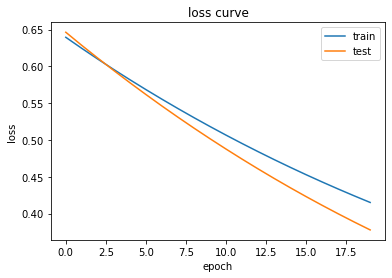

In [24]:
plt.figure()
plt.plot(epoch_all,loss_all)
plt.plot(epoch_all, loss_all_val)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss curve')
plt.legend(['train', 'test'])


# accuracy curve plot

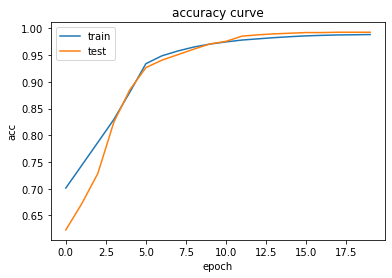

In [25]:
plt.figure()
plt.plot(epoch_all,acc_all)
plt.plot(epoch_all, acc_all_val)
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('accuracy curve')
plt.legend(['train', 'test'])

# score curve plot

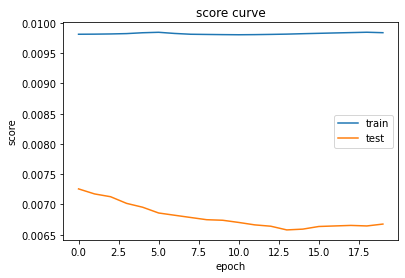

In [26]:
plt.figure()
plt.plot(epoch_all,score_all)
plt.plot(epoch_all, score_all_val)
plt.xlabel('epoch')
plt.ylabel('score')
plt.title('score curve')
plt.legend(['train', 'test'])